In [1]:
# Import libraries
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import yfinance as yf
import seaborn as sns
import scipy.stats as stats

### Section 1 
Here we will import a database of CEO turnover and dismissal in S&P 1500 firms, 2000–2023 from Gentry et al., (2023). The data is available at https://doi.org/10.7910/DVN/6ZQKZI. The data is in the form of a CSV file. We will import the data and take a look at the first few rows of the data.

In [2]:
# Data ingestion
df = pd.read_csv('CEO_Dismissal_Database_9Nov23.csv')
table1 = df.describe().applymap(lambda x: f"{x:0.1f}")
table1

# Sort the df to only account for involuntary CEO dismissals
involuntary = df[df['ceo_dismissal'] == 1]
involuntary = involuntary.reset_index(drop=True)
table2 = involuntary.describe().applymap(lambda x: f"{x:0.1f}")
table2

,dismissal_dataset_id,gvkey,fyear,co_per_rol,departure_code,ceo_dismissal,tenure_no_ceodb
count,1921.0,1921.0,1921.0,1921.0,1921.0,1921.0,1921.0
mean,5056.2,42033.2,2007.7,27692.0,3.1,1.0,1.0
std,2884.8,54344.9,7.8,18571.9,0.3,0.0,0.1
min,13.0,1045.0,1992.0,-33.0,3.0,1.0,1.0
25%,2596.0,7866.0,2001.0,12790.0,3.0,1.0,1.0
50%,5082.0,16116.0,2007.0,25394.0,3.0,1.0,1.0
75%,7548.0,62016.0,2014.0,42827.0,3.0,1.0,1.0
max,10421.0,285085.0,2023.0,70029.0,4.0,1.0,2.0


### Specify the company
We will specify the company for which we want to analyze the CEO turnover. We will use the company's ticker symbol to specify the company. For this analysis, we will use the company's ticker symbol "AAPL" for Apple Inc. Apple Inc is presented in the dataset as 'APPLE INC.' Let's isolate it from the dataset and take a look at the dismissals that have occured in Apple.  

In [3]:
# Apple dismissals
apple = involuntary[involuntary['coname'] == 'APPLE INC']
apple

# Let's clean up the columns and only keep the ones we need
apple = apple.reset_index(drop=True)
apple = apple[['coname', 'fyear', 'exec_fullname', 'departure_code', 'ceo_dismissal', 'date_departure_announced']]
apple

# Transform date_departure_announced values to datetime
apple['date_departure_announced'] = pd.to_datetime(apple['date_departure_announced'])
apple

# Add quarter column to the data
apple['departure_quarter'] = apple['date_departure_announced'].dt.quarter
apple

,coname,fyear,exec_fullname,departure_code,ceo_dismissal,date_departure_announced,departure_quarter
0,APPLE INC,1993,John Sculley,3.0,1.0,1993-06-18,2
1,APPLE INC,1995,Michael H. Spindler,3.0,1.0,1996-02-02,1
2,APPLE INC,1997,Gilbert F. Amelio,3.0,1.0,1997-07-09,3


### Section 2
Now we will get the financial data for Apple Inc and analyze the stock price movement around the CEO turnover events. We will use the Yahoo Finance API to get the stock price data for Apple Inc. We will get the stock price data for the period of 1992-2023. We will then plot the stock price movement around the CEO turnover events.

In [4]:
# Get financial data from yFinance
data = yf.download("AAPL", start="1992-01-01", end="2024-01-01")

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Move the date index to a column
data.reset_index(level=[0], inplace=True)
data.rename(columns={'level_0': 'Date'}, inplace=True)

# Keep the relevant columns 
data = data[['Date','Adj Close','Volume']]
# Transform the Date column to datetime
data = pd.DataFrame(data)
data['Date'] = pd.to_datetime(data['Date'])
# Round adj close to 2 decimal places
data['Adj Close'] = data['Adj Close'].round(2)
# Add quarter column to the data
data['Quarter'] = data['Date'].dt.quarter
data

,Date,Adj Close,Volume,Quarter
0,1992-01-02,0.43,233632000,1
1,1992-01-03,0.43,190254400,1
2,1992-01-06,0.42,114240000,1
3,1992-01-07,0.43,141467200,1
4,1992-01-08,0.44,232747200,1
...,...,...,...,...
8054,2023-12-22,193.35,37122800,4
8055,2023-12-26,192.80,28919300,4
8056,2023-12-27,192.90,48087700,4
8057,2023-12-28,193.33,34049900,4


### Merge the data
Now we will merge the two datasets to get the CEO turnover events for Apple Inc and the stock price data for Apple Inc in a single dataset. We will then plot the stock price movement around the CEO turnover events. 

In [6]:
apple = apple[['date_departure_announced','departure_quarter']]
apple

,date_departure_announced,departure_quarter
0,1993-06-18,2
1,1996-02-02,1
2,1997-07-09,3


In [7]:
# Add ceo dismissal related columns to the df
data['coname'] = 'APPLE INC'
data['ceo_dismissal'] = 0
data
apple_df = pd.concat([data, apple], axis=1)

# Manually add dismissal to the financial data
apple_df.at[370, 'ceo_dismissal'] = 1
apple_df.at[1034, 'ceo_dismissal'] = 1
apple_df.at[1395, 'ceo_dismissal'] = 1
apple_df = apple_df[['Date','Adj Close', 'Volume', 'Quarter', 'coname', 'ceo_dismissal']]
date_index = apple_df.loc[apple_df['Date'] == '1997-09-16'].index[0]
apple_df


,Date,Adj Close,Volume,Quarter,coname,ceo_dismissal
0,1992-01-02,0.43,233632000,1,APPLE INC,0
1,1992-01-03,0.43,190254400,1,APPLE INC,0
2,1992-01-06,0.42,114240000,1,APPLE INC,0
3,1992-01-07,0.43,141467200,1,APPLE INC,0
4,1992-01-08,0.44,232747200,1,APPLE INC,0
...,...,...,...,...,...,...
8054,2023-12-22,193.35,37122800,4,APPLE INC,0
8055,2023-12-26,192.80,28919300,4,APPLE INC,0
8056,2023-12-27,192.90,48087700,4,APPLE INC,0
8057,2023-12-28,193.33,34049900,4,APPLE INC,0


### Section 3
We will now analyze the stock price movement around the CEO turnover events. We will calculate the stock price movement before and after the CEO turnover events. We will then plot the stock price movement before and after the CEO turnover events.

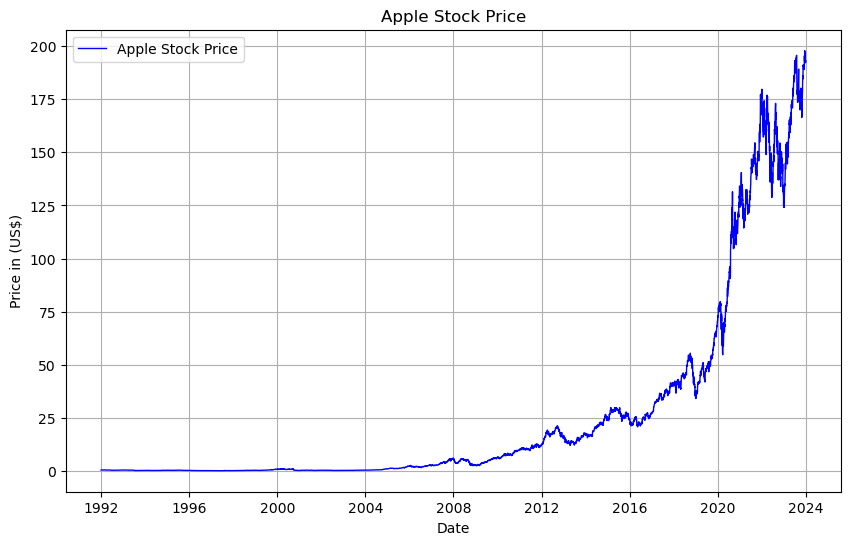

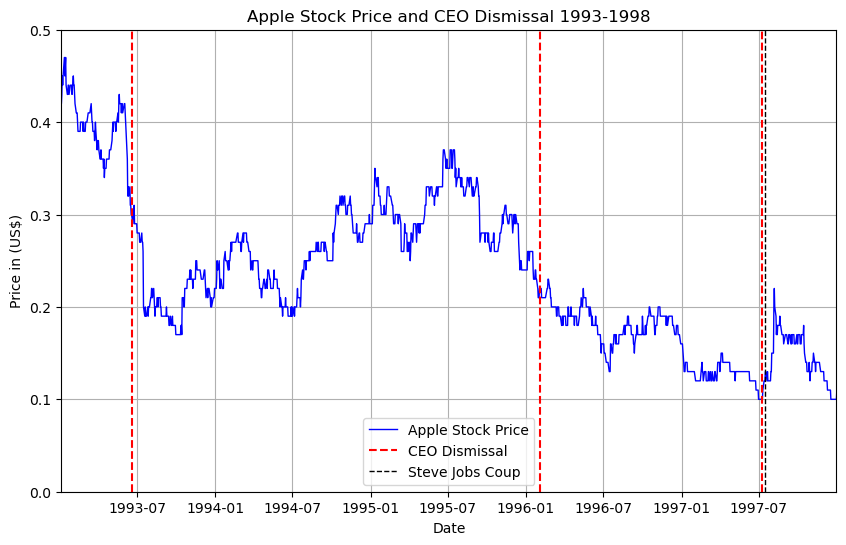

In [78]:
# Visualize the stock price over time and CEO dismissal
plt.figure(figsize=(10,6))
plt.plot(apple_df['Date'], apple_df['Adj Close'], label='Apple Stock Price', color='blue', linewidth=1)
plt.title('Apple Stock Price')
plt.xlabel('Date')
plt.ylabel('Price in (US$)')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10,6))
plt.plot(apple_df['Date'], apple_df['Adj Close'], label='Apple Stock Price', color='blue', linewidth=1)
plt.title('Apple Stock Price and CEO Dismissal 1993-1998')
plt.xlabel('Date')
plt.ylabel('Price in (US$)')
plt.axvline(x=apple_df['Date'][370], color='red', linestyle='--', label='CEO Dismissal')
plt.axvline(x=apple_df['Date'][1034], color='red', linestyle='--')
plt.axvline(x=apple_df['Date'][1395], color='red', linestyle='--')
plt.axvline(x=apple_df['Date'][1400], color='black', linestyle='--', label='Steve Jobs Coup', linewidth=1)
plt.xlim(apple_df[apple_df['Date'] >= '1993-01-01']['Date'].min(), apple_df[apple_df['Date'] <= '1998-01-01']['Date'].max())
plt.ylim(0,0.5)
plt.legend()
plt.grid()
plt.show()


### Standardize the data
We will standardize the data so that x values and price values are in the same range [0,1]. 

In [9]:
# Standardize date
date_min = apple_df['Date'].min()
date_range = apple_df['Date'].max() - apple_df['Date'].min()
date_range # 11684 days
date_data = (apple_df['Date'] - date_min) / date_range 

# Standardize adj close
adj_close_min = apple_df['Adj Close'].min()
adj_close_range = apple_df['Adj Close'].max() - apple_df['Adj Close'].min()
adj_close_data = (apple_df['Adj Close'] - adj_close_min) / adj_close_range
adj_close_data

0       0.001669
1       0.001669
2       0.001618
3       0.001669
4       0.001719
          ...   
8054    0.977195
8055    0.974413
8056    0.974919
8057    0.977093
8058    0.971784
Name: Adj Close, Length: 8059, dtype: float64

### Section 4 
Model comparison. Now that we have the stock price movement around the CEO turnover events, we will use PyMC library to compare the stock price movement around the CEO turnover events using different models. We will use the following models. 

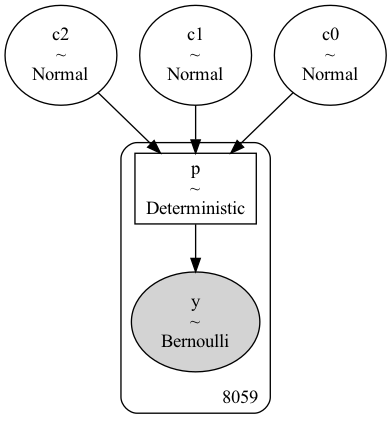

In [10]:
# Turn the predictor and outcome variables into numpy arrays to satisfy the PyMC model
adjusted_close = np.array(adj_close_data)
ceo_dismissal = np.array(apple_df['ceo_dismissal'])

# Set up the model
with pm.Model() as model1:
    # Priors
    c0 = pm.Normal('c0', mu=0, sigma=1)
    c1 = pm.Normal('c1', mu=0, sigma=1)
    c2 = pm.Normal('c2', mu=0, sigma=1)

    # linear model
    logits = c0 + c1 * adjusted_close + c2 * date_data

    # Probit link function for probability of CEO dismissal
    p = pm.Deterministic('p', pm.math.invlogit(logits))
    
    # Likelihood
    y = pm.Bernoulli('y', p=p, observed=ceo_dismissal)
# Visualize the model
from IPython.display import Image
Image(pm.model_to_graphviz(model1).render(format='png'))

In [11]:
# Run the inference
with model1:
    trace1 = pm.sample()
    pm.sample_posterior_predictive(trace1, extend_inferencedata=True)
    pm.compute_log_likelihood(trace1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, c2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Sampling: [y]


Output()

Output()

In [81]:
var_names = ['c0', 'c1', 'c2']
az.summary(trace1, var_names)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,-5.894,0.388,-6.598,-5.154,0.008,0.006,2420.0,2775.0,1.0
c1,-0.374,0.933,-2.060,1.480,0.015,0.013,3772.0,2765.0,1.0
c2,-2.417,0.795,-3.854,-0.909,0.015,0.011,2667.0,2734.0,1.0


array([<Axes: title={'center': 'c0'}>, <Axes: title={'center': 'c1'}>,
       <Axes: title={'center': 'c2'}>], dtype=object)

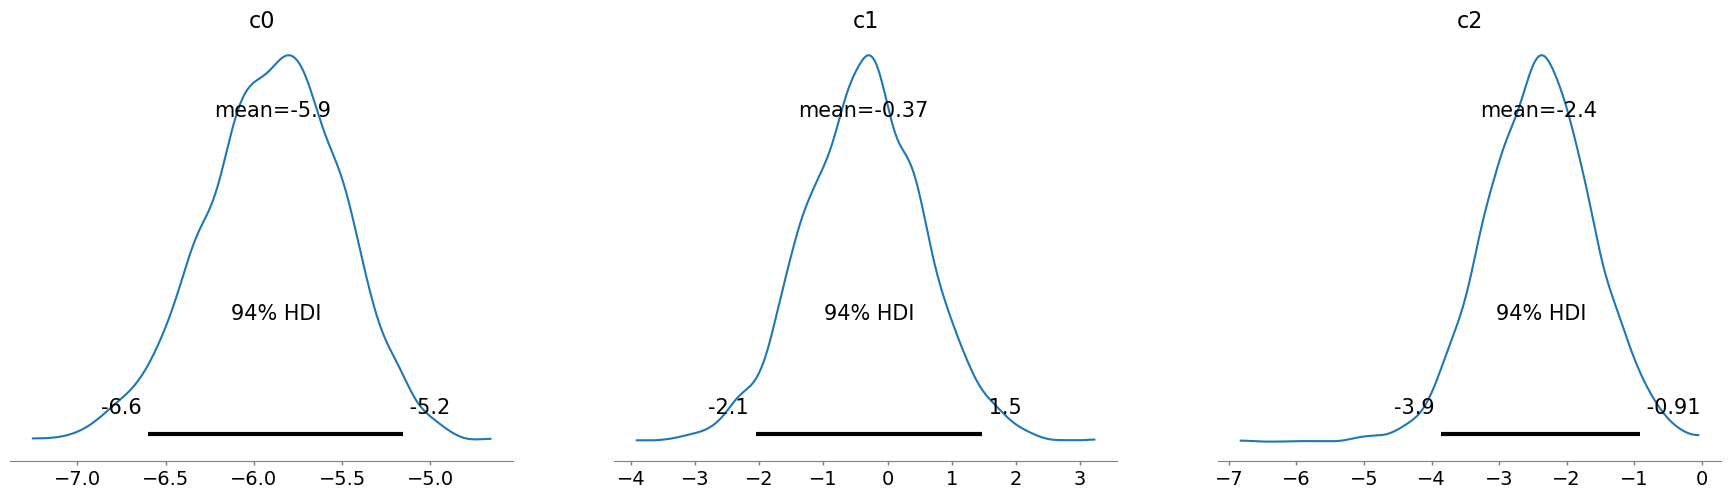

In [82]:
pm.plot_posterior(trace1, var_names)

array([<Axes: title={'center': 'c0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'c2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

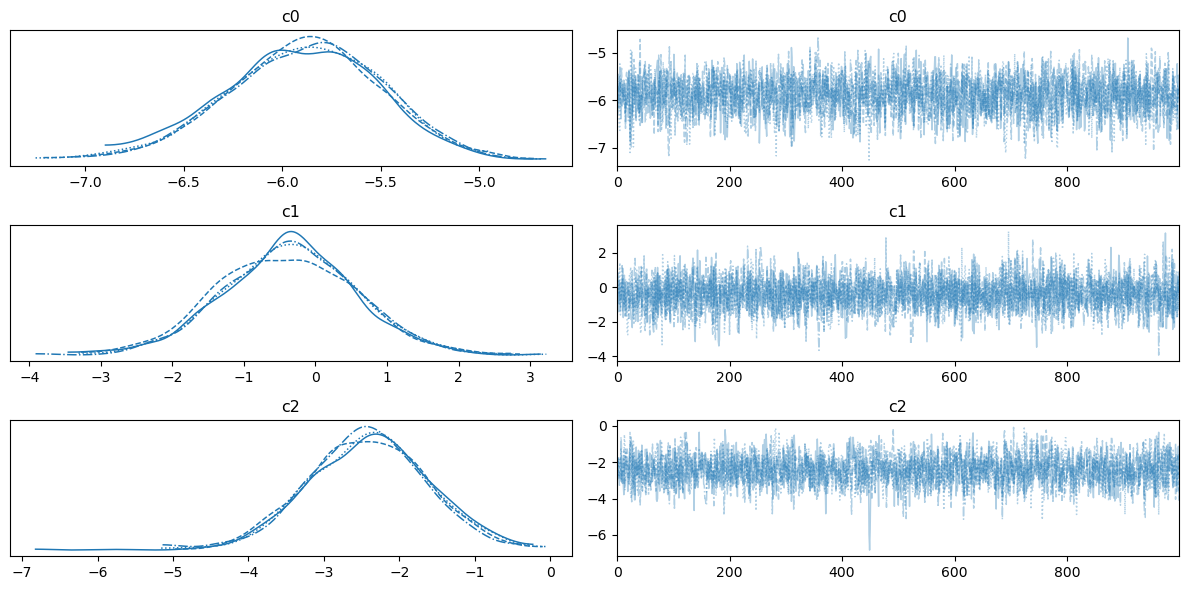

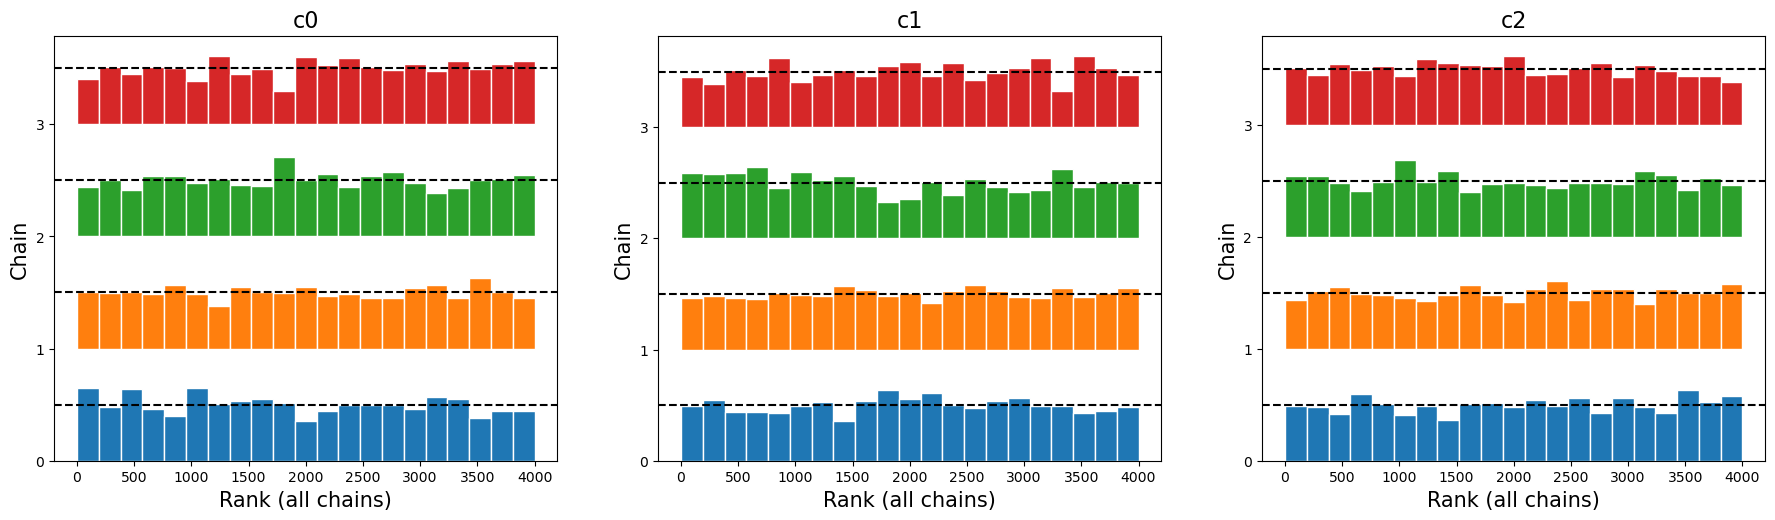

In [13]:
az.plot_trace(trace1, var_names)
plt.tight_layout()
az.plot_rank(trace1, var_names)

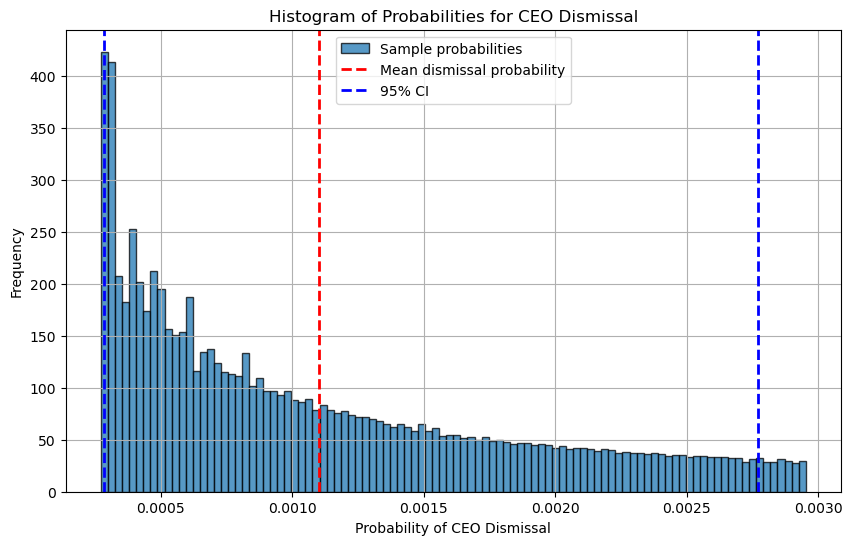

In [45]:
posterior = trace1.posterior
probabilities = posterior['p'].values
mean_prob_dismissal_logit = probabilities.mean(axis = (0,1))
mean_prob_dismissal_logit
plt.figure(figsize=(10, 6))
plt.hist(mean_prob_dismissal_logit, bins=100, alpha=0.75, edgecolor='black', label='Sample probabilities')
plt.axvline(x=np.mean(mean_prob_dismissal_logit), color='red', linestyle='dashed', linewidth=2, label='Mean dismissal probability')
plt.axvline(x=np.percentile(mean_prob_dismissal_logit, 2.5), color='blue', linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(x=np.percentile(mean_prob_dismissal_logit, 97.5), color='blue', linestyle='dashed', linewidth=2)  
plt.xlabel('Probability of CEO Dismissal')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.title('Histogram of Probabilities for CEO Dismissal')
plt.show()

In [15]:
# Posterior predictive
values = trace1.posterior_predictive.y.values.flatten()

In [16]:
print(f'Probability of CEO dismissal given Stock Price: {np.mean(values):0.6f}')

Probability of CEO dismissal given Stock Price: 0.001101


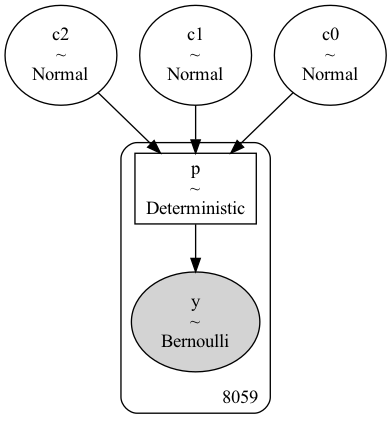

In [17]:
# Set up the model
with pm.Model() as model2:
    # Priors
    c0 = pm.Normal('c0', mu=0, sigma=1)
    c1 = pm.Normal('c1', mu=0, sigma=1)
    c2 = pm.Normal('c2', mu=0, sigma=1)

    # linear model
    logits = c0 + c1 * adjusted_close + c2 * date_data

    # Probit link function for probability of CEO dismissal
    p = pm.Deterministic('p', pm.math.invprobit(logits))
    
    # Likelihood
    y = pm.Bernoulli('y', p=p, observed=ceo_dismissal)
# Visualize the model
from IPython.display import Image
Image(pm.model_to_graphviz(model2).render(format='png'))

In [18]:
# Run the inference
with model2:
    trace2 = pm.sample()
    pm.sample_posterior_predictive(trace2, extend_inferencedata=True)
    pm.compute_log_likelihood(trace2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, c2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Output()

Output()

In [28]:
az.summary(trace2, var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,-2.852,0.204,-3.228,-2.473,0.005,0.003,1904.0,1963.0,1.0
c1,-0.247,0.898,-1.995,1.335,0.020,0.014,1894.0,2314.0,1.0
c2,-1.601,0.652,-2.868,-0.455,0.016,0.011,1717.0,2230.0,1.0


array([<Axes: title={'center': 'c0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'c2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

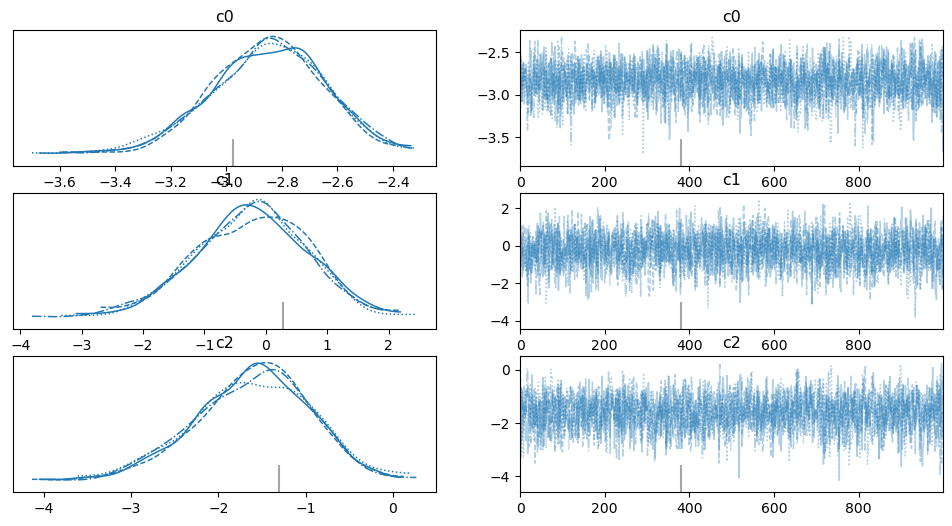

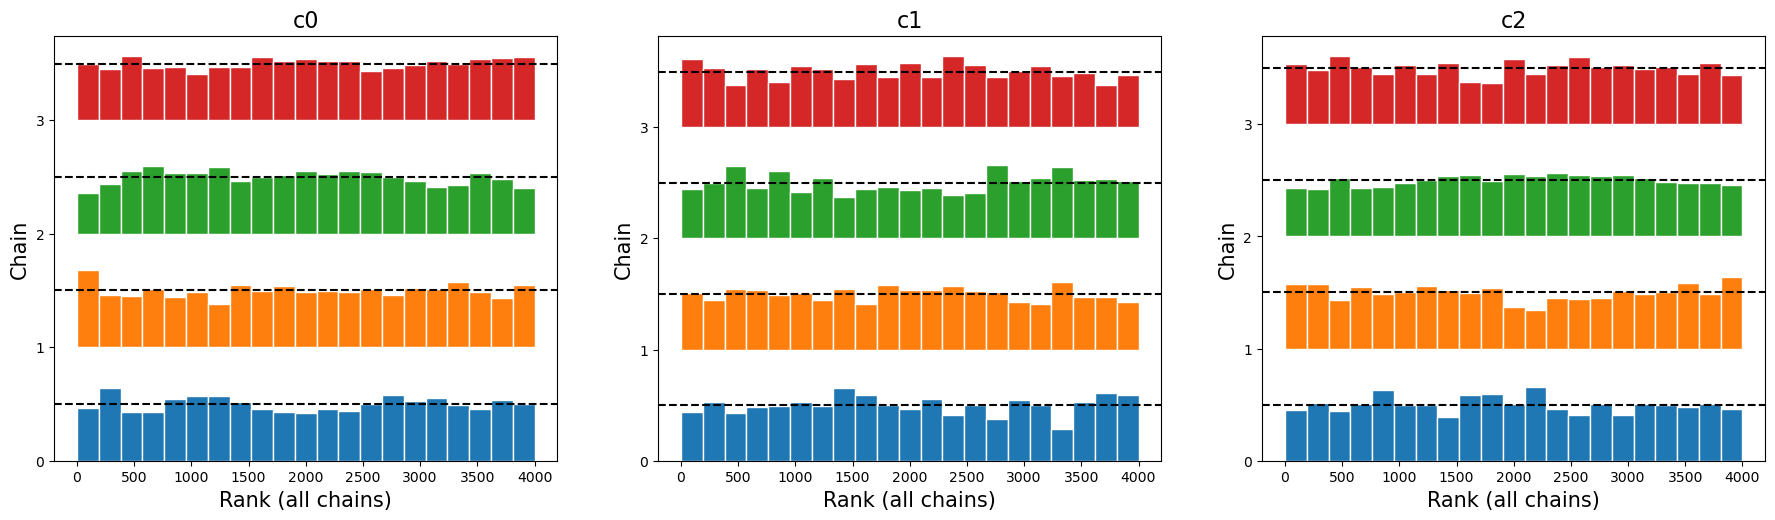

In [27]:
az.plot_trace(trace2, var_names)
az.plot_rank(trace2, var_names)

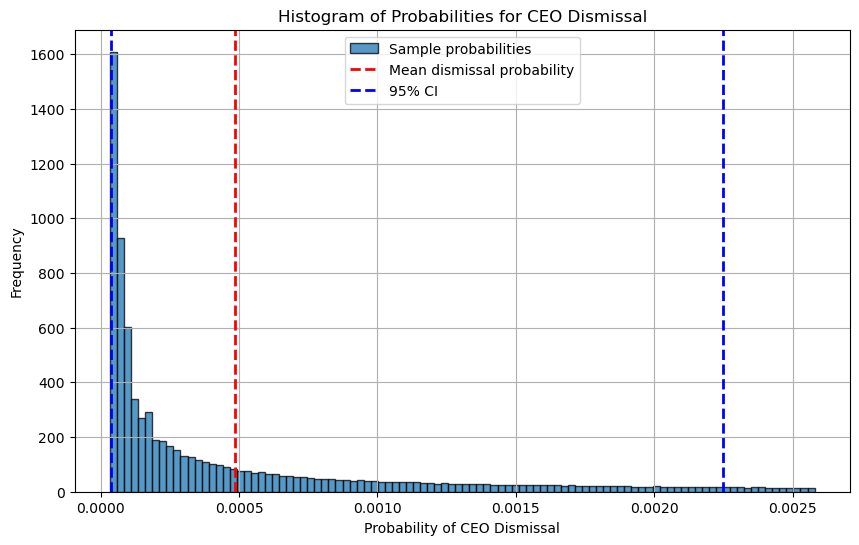

In [46]:
posterior = trace2.posterior
probabilities = posterior['p'].values
mean_prob_dismissal_probit = probabilities.mean(axis = (0,1))
mean_prob_dismissal_probit
plt.figure(figsize=(10, 6))
plt.hist(mean_prob_dismissal_probit, bins=100, alpha=0.75,  edgecolor='black', label='Sample probabilities')
plt.axvline(x=np.mean(mean_prob_dismissal_probit), color='red', linestyle='dashed', linewidth=2, label='Mean dismissal probability')
plt.axvline(x=np.percentile(mean_prob_dismissal_probit, 2.5), color='blue', linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(x=np.percentile(mean_prob_dismissal_probit, 97.5), color='blue', linestyle='dashed', linewidth=2)  
plt.xlabel('Probability of CEO Dismissal')
plt.ylabel('Frequency')
plt.title('Histogram of Probabilities for CEO Dismissal')
plt.legend()
plt.grid()
plt.show()

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Probit Model,0,49.395767,1.005589,0.0000,1.000000e+00,24.015679,0.00000,False,deviance
Logit Model,1,55.157467,0.364183,5.7617,2.220446e-15,21.603928,2.44722,False,deviance


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

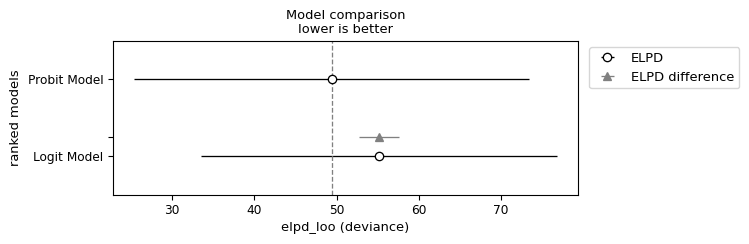

In [79]:
results = az.compare({'Logit Model': trace1, 'Probit Model': trace2}, ic='loo', scale='deviance') 
display(results)
az.plot_compare(results)

In [77]:
# Credible intervals
print(f'Mean probability of CEO dismissal given Stock Price: {np.mean(values):0.6f}')
print(f'Lower 95% Credible Interval for the Logit model: {np.percentile(mean_prob_dismissal_logit, 2.5):0.6f} and upper 95% CI: {np.percentile(mean_prob_dismissal_logit, 97.5):0.6f}')
print(f'Lower 95% Credible Interval for the Probit model: {np.percentile(mean_prob_dismissal_probit, 0.025):0.6f} and upper 95% CI: {np.percentile(mean_prob_dismissal_probit, 97.5):0.6f}')

Mean probability of CEO dismissal given Stock Price: 0.001101
Lower 95% Credible Interval for the Logit model: 0.000283 and upper 95% CI: 0.002771
Lower 95% Credible Interval for the Probit model: 0.000034 and upper 95% CI: 0.002249
